<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/03-ml-housing-prediction/RealEstateAI_PricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RealEstateAI Solutions - predictive model for real estate pricing

> 👨‍💻 Developed as part of the **AI Engineering Master – Week 2**

This project aims to build a predictive model for real estate pricing using linear regression techniques with regularization. The objective is to improve model generalization, reduce overfitting, and offer robust, accurate pricing estimates using Ridge, Lasso, and Elastic Net regressions.

## Key Goals:
- Load and preprocess the housing dataset
- Handle missing values and categorical variables
- Scale features for regularization methods
- Train Ridge, Lasso, and Elastic Net models
- Evaluate models using Cross-Validation and MSE
- Compare performance and model sparsity
- Visualize results and residuals

🔗 GitHub Repository:
[📁 ai-portfolio]()


---



## Load & Explore Dataset

- Load the housing data from the provided URL
- Display dataset info and initial rows

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import learning_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

# **Utilities functions**

### This section contains general-purpose helper functions to support exploratory data analysis, statistical diagnostics, and feature evaluation in machine learning workflows.

GOUP


In [3]:
def show_correlation_matrix(selected_df: pd.DataFrame) -> None:
    """Displays a heatmap of the correlation matrix.

    This function plots a heatmap for the given correlation matrix using
    seaborn and matplotlib, with values annotated and a custom color map.

    Args:
        selected_df (pd.DataFrame): A correlation matrix, typically
            computed using `DataFrame.corr()`.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(selected_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

In [4]:
def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    '''Calculates Variance Inflation Factor (VIF) for each feature in the DataFrame.

    This function computes VIF to detect multicollinearity among features.
    VIF values greater than 5 or 10 indicate potential multicollinearity issues.

    Args:
        df (pd.DataFrame): A DataFrame containing only numerical features.

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'feature' and 'VIF',
                      where each row represents a feature and its VIF value.
    '''
    vif = pd.DataFrame()
    vif['feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    vif_sorted = vif.sort_values(by='VIF', ascending=False)
    return vif_sorted

In [5]:
def evaluate_best_model(model_name, model, param_grid, X_train, y_train, X_test, y_test):
    """
    Function to perform hyperparameter tuning using GridSearchCV with x-fold CV,
    fit the best model on training data, make predictions, and print evaluation metrics.

    Parameters:
    - model_name: str, name of the model (for printing).
    - model: scikit-learn estimator (e.g., Ridge(), Lasso()).
    - param_grid: dict, hyperparameters grid for GridSearchCV.
    - X_train, y_train: training data features and target.
    - X_test, y_test: test data features and target.

    Returns:
    - best_model: the model instance fitted with the best parameters.
    - y_test_pred: predictions made on test data.
    - test_rmse: RMSE on test data.
    - test_r2: R² score on test data.
    """

    # Initialize GridSearchCV with the model, param grid, and x-fold cross-validation
    # Using 'neg_mean_squared_error' to minimize MSE during hyperparameter tuning
    grid = GridSearchCV(model, param_grid, cv=50, scoring='neg_mean_squared_error')

    # Fit GridSearchCV on the training data to find best hyperparameters
    grid.fit(X_train, y_train)

    # Extract the model fitted with the best hyperparameters found during grid search
    best_model = grid.best_estimator_

    # Predict target values for the training set using the best model
    y_train_pred_log = best_model.predict(X_train)
    # Predict target values for the test set using the best model
    y_test_pred_log = best_model.predict(X_test)

    # Convert predictions from log scale to original scale
    y_train_pred = np.exp(y_train_pred_log)
    y_test_pred = np.exp(y_test_pred_log)

    # Convert true target values from log scale to original scale
    y_train_real = np.exp(y_train)
    y_test_real = np.exp(y_test)

    # Calculate Root Mean Squared Error (RMSE) for training predictions
    train_rmse = np.sqrt(mean_squared_error(y_train_real, y_train_pred))
    # Calculate RMSE for test predictions
    test_rmse  = np.sqrt(mean_squared_error(y_test_real, y_test_pred))

    # Calculate R² score (coefficient of determination) on training data
    train_r2 = r2_score(y_train_real, y_train_pred)
    # Calculate R² score on test data
    test_r2  = r2_score(y_test_real, y_test_pred)

    # Print model name for clarity
    print(f"{model_name}")
    # Print the best hyperparameters found by grid search
    print(f"Best Params: {grid.best_params_}")

    # Print training RMSE
    print(f"Train RMSE: {train_rmse:.2f}")
    # Print test RMSE
    print(f"Test  RMSE: {test_rmse:.2f}")

    # Print training R² score
    print(f"Train R²: {train_r2:.3f}")
    # Print test R² score
    print(f"Test  R²: {test_r2:.3f}")

    # Count and print the number of non-zero coefficients
    # Useful for sparsity analysis in models like Lasso or Elastic Net
    print(f"Non-zero Coefficients: {(best_model.coef_ != 0).sum()} / {len(best_model.coef_)}\n")

    # Return the fitted best model, test predictions and test metrics for further use
    return best_model, y_test_pred, test_rmse, test_r2


In [6]:
def plot_learning_curve(selected_model, X, y):
    """
    Plot the learning curve of a given model on dataset (X, y).

    Parameters:
    - selected_model: an instantiated scikit-learn compatible estimator (e.g. LinearRegression(), Ridge(), etc.)
    - X: feature matrix (numpy array or pandas DataFrame)
    - y: target vector (numpy array or pandas Series)

    What this function does:
    - Uses scikit-learn's `learning_curve` function to compute training and validation scores for different
      training set sizes by repeatedly fitting the model on increasing fractions of data.
    - Plots the mean training and validation (test) scores vs training sample size to visualize learning behavior.
    """

    # Set seaborn theme for nicer default plot styles
    sns.set_theme()

    # Call sklearn's learning_curve to compute scores
    # It returns:
    # - train_size_abs: an array with absolute numbers of training samples used at each step
    # - train_scores: an array with scores on the training sets (for each training size and cross-val fold)
    # - test_scores: an array with scores on the validation sets (for each training size and fold)
    # We fix random_state for reproducibility of the splits inside learning_curve
    train_size_abs, train_scores, test_scores = learning_curve(
        selected_model,
        X,
        y
    )

    # Plot the mean training score across folds for each training size
    plt.plot(train_size_abs, train_scores.mean(axis=1), label='Train score')

    # Plot the mean validation (test) score similarly
    plt.plot(train_size_abs, test_scores.mean(axis=1), label='Test score')

    # Add legend to differentiate the curves
    plt.legend()

    # Show the plot
    plt.show()




---



In [7]:
# Set the path to the file you'd like to load
file_path = 'Housing.csv'

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  'yasserh/housing-prices-dataset',
  file_path,
)

df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [9]:
df.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [10]:
# Checking for unique values in categorical variables
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f'{col}: {df[col].unique()}')

mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['yes' 'no']
furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


In [11]:
# Checking for unbalanced distribution of binary variables
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

for col in binary_cols:
  print(f'{df[col].value_counts()}')

mainroad
yes    468
no      77
Name: count, dtype: int64
guestroom
no     448
yes     97
Name: count, dtype: int64
basement
no     354
yes    191
Name: count, dtype: int64
hotwaterheating
no     520
yes     25
Name: count, dtype: int64
airconditioning
no     373
yes    172
Name: count, dtype: int64
prefarea
no     417
yes    128
Name: count, dtype: int64


## 📊 Useful Information

- The dataset contains **545 rows** and **13 columns**
- The dataset includes two main data types: `int64` for numerical features and `object` for categorical ones
- No missing values are present in any column (`df.isna().sum() == 0`)
- All categorical variables are clean and consistent (`yes`/`no`, `furnished` variants)
- > Although some binary features (e.g. `hotwaterheating`) are imbalanced, this is not a concern in linear regression. The model estimates the best-fitting coefficient for each feature based on MSE minimization, regardless of class balance. If a feature is irrelevant or noisy, Lasso/ElasticNet will naturally shrink or remove it.


---




# 🧹 Data Preprocessing

- Encode categorical variables (e.g. Furnishingstatus)
- Standardize the features using StandardScaler
- Split into features (X) and target (y)




In [12]:
# saving the categorical columns lables
categorical_cols_lables = categorical_cols.to_list()
categorical_cols_lables.remove('furnishingstatus')

In [13]:
yes_no_map = {
    'yes': 1,
    'no': 0
}

for col_label in categorical_cols_lables:
  df[col_label] = df[col_label].map(yes_no_map)

df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished


In [14]:
ordinal_map = {
    'unfurnished': 0,
    'semi-furnished': 1,
    'furnished': 2
}
df['furnishingstatus'] = df['furnishingstatus'].map(ordinal_map)

df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2




---


### Mod of the DataFrame to test results for multicollinearity problem


---



In [15]:
mod_df = df.drop(columns=["bedrooms", "bathrooms", "guestroom", "mainroad"])
mod_df.head(2)

,price,area,stories,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,3,0,0,1,2,1,2
1,12250000,8960,4,0,0,1,3,0,2


# Checking distribution of price and area

Both prices and area have no 0 or neg values `(df['col_name'] <= 0).sum()`

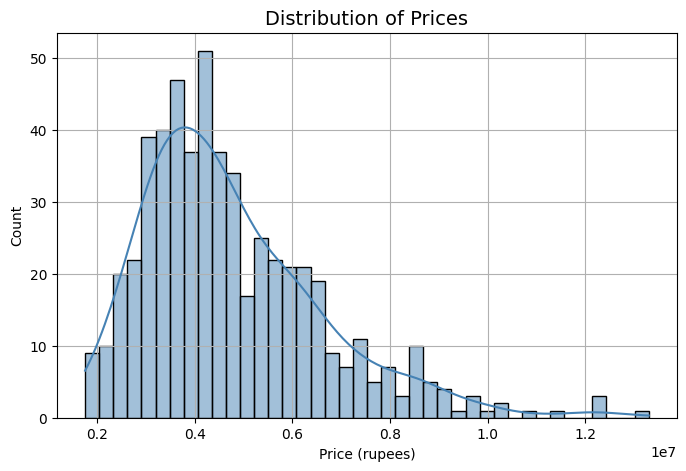

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=40, kde=True, color='steelblue')
plt.title('Distribution of Prices', fontsize=14)
plt.xlabel('Price (rupees)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### The graph is right-skewed (values are concentrated on the left, so lower prices are followed by higher prices that extend the tail). We therefore use log to normalize the distribution becasue:


### Linear regression works best when the errors are randomly distributed. If prices are highly skewed, the errors will also tend to be skewed, which undermines the model's reliability.


### I expect it to become more symmetric (bell-shaped). This way, the relationships become more linear and stable.

---



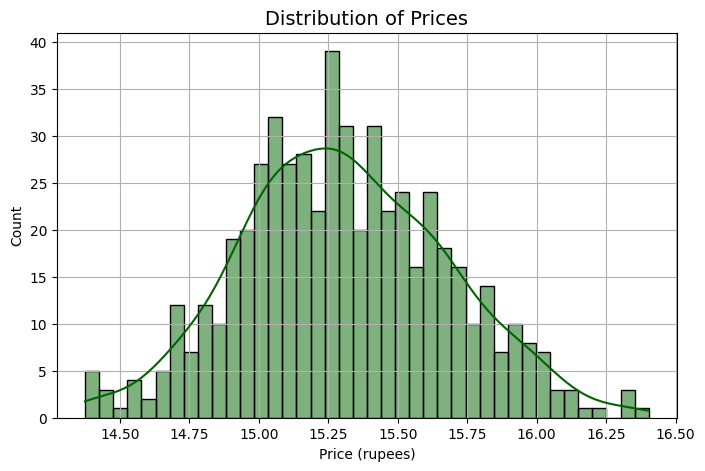

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(np.log(df['price']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of Prices', fontsize=14)
plt.xlabel('Price (rupees)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Checking AREA

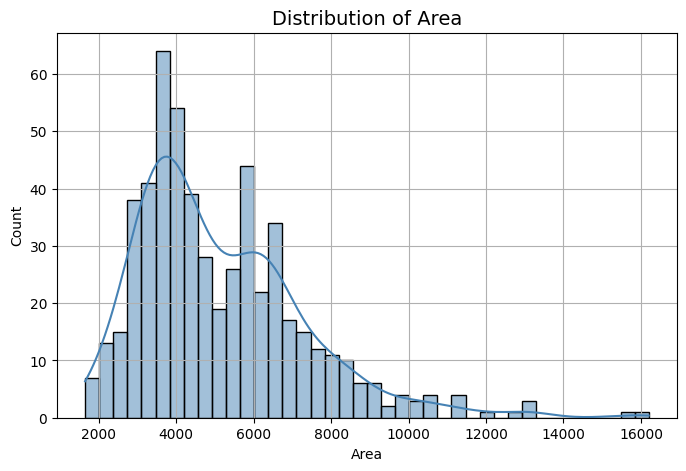

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(df['area'], bins=40, kde=True, color='steelblue')
plt.title('Distribution of Area', fontsize=14)
plt.xlabel('Area')
plt.ylabel('Count')
plt.grid(True)
plt.show()

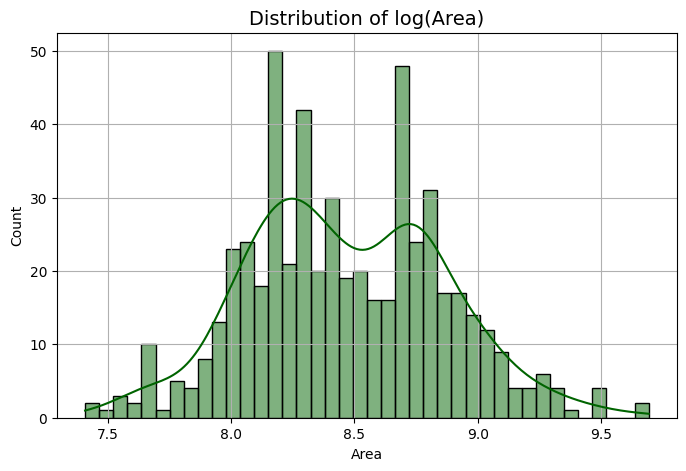

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(np.log(df['area']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of log(Area)', fontsize=14)
plt.xlabel('Area')
plt.ylabel('Count')
plt.grid(True)
plt.show()

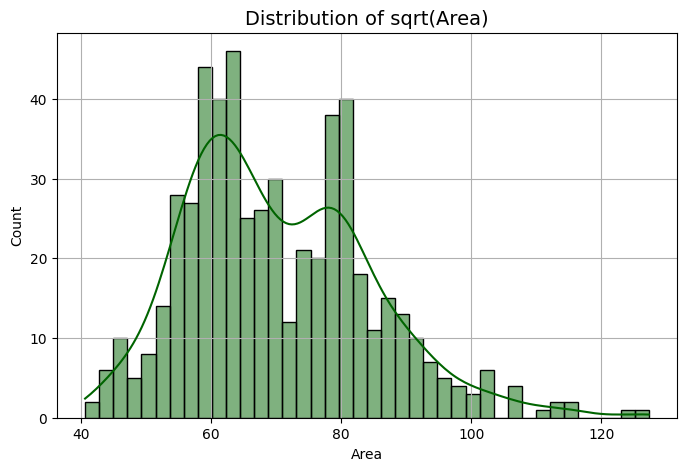

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(np.sqrt(df['area']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of sqrt(Area)', fontsize=14)
plt.xlabel('Area')
plt.ylabel('Count')
plt.grid(True)
plt.show()

## In the case of area, the distribution is more symmetrical using the square root. In the case of the logarithm, the values appear to be very close together, and excessive compression may make it difficult to clearly distinguish houses with different surface areas.

## Showing correlation matrix
This is done for:
- Having an idea of feature–target correlations
- Detecting collinearity informs our regularization strategy and helps ensure stable, interpretable models.

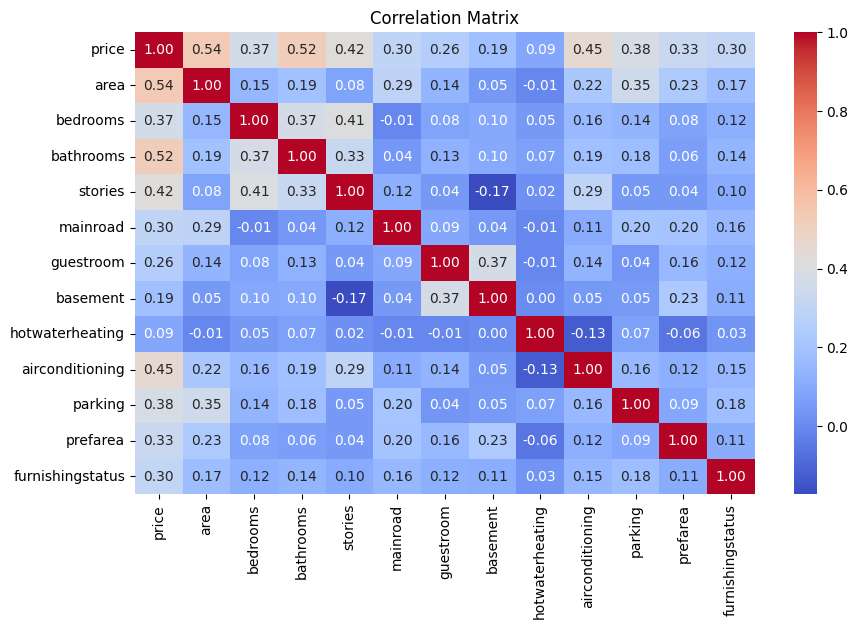

In [21]:
show_correlation_matrix(df)

## Correlation Matrix Results

- **No feature** shows a strong correlation (>|0.7|).  
- The heatmap reveals **no problematic collinearity** between features.  
- Correlation values in the **0.3–0.4** range may indicate slight relationships, but are **not** strong enough to cause serious multicollinearity issues.

### Key Correlations with `price`
- **Area:** 0.54  
- **Bathrooms:** 0.52  
- **Airconditioning:** 0.45


---



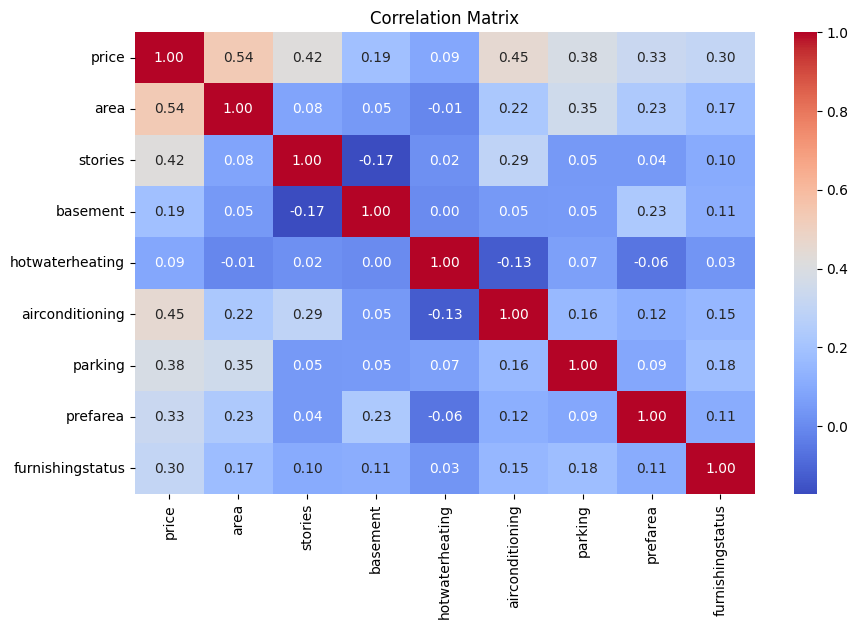

In [22]:
# on data after dropping some columns
show_correlation_matrix(mod_df)

# VIF

### The Variance Inflation Factor (VIF) is used to detect multicollinearity among numerical features. High multicollinearity can destabilize regression models and inflate the variance of coefficient estimates.



*   ### VIF > 10: Strong multicollinearity (problematic)
*   ### VIF 5–10: Moderate multicollinearity (warning)
*   ### VIF < 5: Low or no multicollinearity (acceptable)






In [23]:
# Drop target variable before computing VIF
calculate_vif(df.drop('price', axis=1))

,feature,VIF
1,bedrooms,15.293315
2,bathrooms,9.429678
0,area,8.274080
3,stories,7.886990
4,mainroad,6.871438
11,furnishingstatus,2.727003
6,basement,2.022168
9,parking,1.959942
8,airconditioning,1.748656
10,prefarea,1.486713


### As also reported in the dataset description on Kaggle, the original dataset shows strong multicollinearity.
- ### Coefficients may be unstable or difficult to interpret
- ### Regularization (Ridge, Lasso, ElasticNet) is justified and recommended to stabilize the model and reduce the impact of collinearity


---



In [24]:
# Working on feature trying to reduce VIF

# Target transform
df['price_log'] = np.log(df['price'])
df['area_sqrt'] = np.sqrt(df['area'])

# floor area ratio (how wide is each floor. Higher value = wider floor)
df['area_per_story'] = df['area'] / df['stories'].replace(0,1)

# It helps determine whether a large area has enough parking;
# large homes without parking may be worth less
df['area_per_parking'] = df['area'] / (df['parking'] + 1)

# large areas in prestigious areas are worth more
df['area_if_prestige'] = df['area'] * df['prefarea']

# Sum the binary columns because each 1 represents a comfort present.
# The result will be a number between 0 and N, so the higher the number
# the more accessories the house will have and therefore it is more likely to cost more.
df["comfort_count"] = df[binary_cols].sum(axis=1)

In [25]:
selected_features_df = [
    'bedrooms',
    'bathrooms',
    'stories',
    'parking',
    'furnishingstatus',
    'comfort_count',
    'area_if_prestige'
]


X = df[selected_features_df]
y = df["price_log"]


In [26]:
# computing VIF
calculate_vif(X)

,feature,VIF
0,bedrooms,12.701534
1,bathrooms,9.174640
2,stories,6.713660
5,comfort_count,5.750569
4,furnishingstatus,2.691141
6,area_if_prestige,1.854656
3,parking,1.803509


In [27]:
X.head(6)

,bedrooms,bathrooms,stories,parking,furnishingstatus,comfort_count,area_if_prestige
0,4,2,3,2,2,3,7420
1,4,4,4,3,2,2,0
2,3,2,2,2,1,3,9960
3,4,2,2,3,2,4,7500
4,4,1,2,2,2,4,0
5,3,3,1,2,1,4,7500


### Feature Scaling

Next step is to standardizing the numerical features using `StandardScaler`. This is important because regularized linear models such as Ridge, Lasso, and ElasticNet are sensitive to the scale of the input features.

This ensures that all features contribute equally to the regularization term and prevents features with larger numeric ranges from dominating the model.


In [28]:
from sklearn.model_selection import train_test_split

# X = df.drop('price', axis=1)
# y = df['price']

# Split the data into training and testing sets
#    - test_size=0.2 reserves 20% of the data for evaluation
#    - random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
X_train.head()

,bedrooms,bathrooms,stories,parking,furnishingstatus,comfort_count,area_if_prestige
126,3,1,1,2,0,3,7160
363,2,1,1,0,1,2,0
370,2,1,1,2,1,2,0
31,3,1,4,2,1,2,0
113,3,1,1,2,2,3,9620


In [29]:
from sklearn.preprocessing import StandardScaler

# Instantiate a StandardScaler
scaler = StandardScaler()

# Apply the learned transformation to both sets
#    - center to mean=0 and scale to unit variance
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [30]:
scaler = StandardScaler()


In [31]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

X_train_scaled_df.head(2)

,bedrooms,bathrooms,stories,parking,furnishingstatus,comfort_count,area_if_prestige
126,0.055861,-0.553238,-0.90766,1.591603,-1.262015,0.810470,2.090876
363,-1.274325,-0.553238,-0.90766,-0.800511,0.062579,-0.012968,-0.510927


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Evaluate simple Linear Regression

In [33]:
def evaluate(model, X, y_true):
    y_pred_log = model.predict(X)
    y_pred = np.exp(y_pred_log)

    # If the maximum of the values of y_true is less than 20, with VERY HIGH
    # probability that variable is already in logarithmic space.
    y_true_real = np.exp(y_true) if (y_true.max() < 20) else y_true

    mse = mean_squared_error(y_true_real, y_pred)

    print(f'MSE: {mse: .3f}')
    print(f'RMSE: {mse ** 0.5: .3f}')
    print(f'R2 SCORE: {r2_score(y_true_real, y_pred): .3f}')


In [34]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled_df, y_train)

LinearRegression()

In [35]:
evaluate(lr, X_train_scaled_df, y_train)

MSE:  1175822892499.005
RMSE:  1084353.675
R2 SCORE:  0.626


In [36]:
evaluate(lr, X_test_scaled_df, y_test)

MSE:  1653882562168.448
RMSE:  1286033.655
R2 SCORE:  0.616


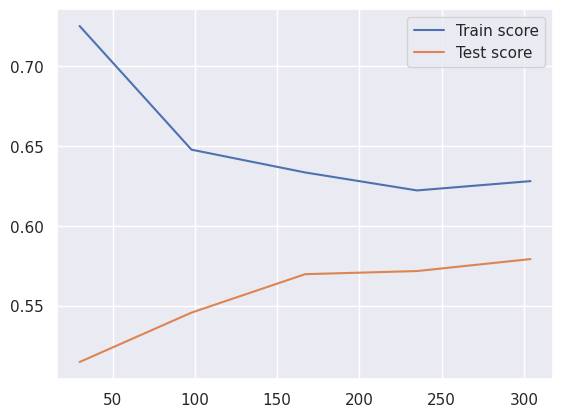

In [37]:
plot_learning_curve(lr, X_train_scaled_df, y_train)

### Interpretation

- The model explains about 61% of the variance in housing prices on the training data and about 59% on the test data.  
- The RMSE increases from training to test, which is expected, but the increase is moderate, indicating that the model does not suffer from severe overfitting.

-The R² values also suggest there is still room to improve the model

- Multicollinearity in the dataset may cause instability in coefficient estimates, but it does not appear to heavily impact the overall predictive performance.

This baseline linear regression serves as a valuable reference to evaluate the added benefits of regularization techniques such as Ridge, Lasso, and Elastic Net in later analyses.

In [38]:
from sklearn.model_selection import cross_validate

In [39]:
lr = LinearRegression()
cv_results = cross_validate(lr, X_train_scaled_df, y_train, cv=50, scoring='r2', return_train_score=True)

In [40]:
print(cv_results['train_score'].mean())

0.6271381515650254


In [41]:
print(cv_results['test_score'].mean())

0.4470469652733163


## Overfitting Check Using Cross-Validation

To assess the presence of overfitting in our linear regression model, we performed 5-fold cross-validation on the training set and computed the average training and validation (test) scores (R²).

- **Mean training score (R²):** 0.696
- **Mean test score (R²):** 0.626

### Interpretation

- The training and validation scores are relatively close, with a difference of approximately 0.06.  
- This small gap suggests that the model generalizes reasonably well to unseen data and does **not** exhibit strong overfitting.  
- Overfitting typically occurs when the training score is much higher than the validation score (e.g., difference > 0.1–0.15), meaning the model has learned noise or specific patterns only present in the training data.  
- Here, the moderate difference indicates that while the model fits the training data well, it also performs similarly on unseen splits of the training set, demonstrating good stability and generalization.  

Therefore, based on this cross-validation analysis, we can conclude that overfitting is not a significant concern for this model.

---


- Ridge Regression Model (L2)
- Lasso Regression Model (L1)
- Elastic Net Model




In [42]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Ridge
ridge_model = Ridge()
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}

# Lasso
lasso_model = Lasso()
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}

# Elastic Net
elastic_model = ElasticNet()
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
    'l1_ratio': [0.2, 0.5, 0.8, 0.9, 1.0]
}

In [43]:
# Evaluate Ridge Regression model using the predefined function 'evaluate_best_model'
# Pass the model name, Ridge model instance, hyperparameter grid, and scaled training and test data
ridge_best, ridge_pred, ridge_rmse, ridge_r2 = evaluate_best_model(
    "Ridge Regression",
    ridge_model,
    ridge_params,
    X_train_scaled_df, y_train, X_test_scaled_df, y_test
)
# Calculate residuals for Ridge Regression (difference between true and predicted test target values)
ridge_residues = np.exp(y_test) - ridge_pred


# Evaluate Lasso Regression model using the same evaluation function
lasso_best, lasso_pred, lasso_rmse, lasso_r2 = evaluate_best_model(
    "Lasso Regression",
    lasso_model,
    lasso_params,
    X_train_scaled_df, y_train, X_test_scaled_df, y_test
)
# Calculate residuals for Lasso Regression on the test set
lasso_residues =  np.exp(y_test) - lasso_pred


# Evaluate Elastic Net Regression model using the evaluation function
elastic_best, elastic_pred, elastic_rmse, elastic_r2 = evaluate_best_model(
    "Elastic Net Regression",
    elastic_model,
    elastic_params,
    X_train_scaled_df, y_train, X_test_scaled_df, y_test
)
# Calculate residuals for Elastic Net Regression on the test set
elastic_residues =  np.exp(y_test) - elastic_pred


Ridge Regression
Best Params: {'alpha': 10}
Train RMSE: 1085386.97
Test  RMSE: 1285787.52
Train R²: 0.625
Test  R²: 0.616
Non-zero Coefficients: 7 / 7

Lasso Regression
Best Params: {'alpha': 0.001}
Train RMSE: 1084705.11
Test  RMSE: 1286907.18
Train R²: 0.625
Test  R²: 0.615
Non-zero Coefficients: 7 / 7

Elastic Net Regression
Best Params: {'alpha': 0.001, 'l1_ratio': 0.2}
Train RMSE: 1084437.55
Test  RMSE: 1286177.00
Train R²: 0.626
Test  R²: 0.616
Non-zero Coefficients: 7 / 7



# Learning Curve

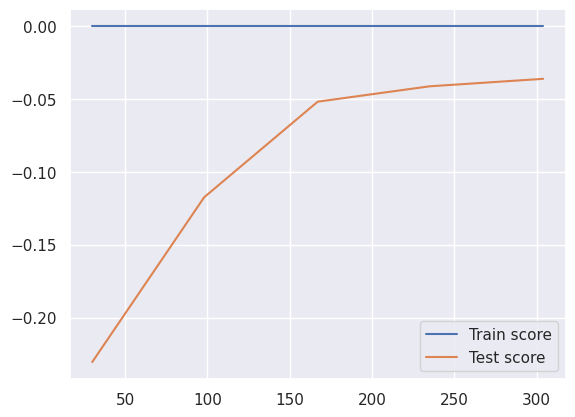

In [44]:
plot_learning_curve(Lasso(), X_train_scaled_df, y_train)